In [30]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(magrittr)
library(zoo)
library(purrr)
library(scales)
library(keras3)
library(neuralnet)
library(stringr)

In [31]:
lista_df_ps = readRDS('../02_Variables/lista_df_ps.rds')

In [32]:
Date = lista_df_ps$df_CA_3_FOODS_3_090$date %>% as.data.frame()

n_registros_date = dim(Date)[1]
Data_size = floor(0.7 * n_registros_date)

Date = Date[(Data_size + 1):n_registros_date, ] %>% as.data.frame()

Date = rename(Date, Fecha = .)

In [33]:
time_model = function(x_train, y_train, x_test, y_test) {

  model = keras_model_sequential() %>% 
    layer_dense(units = 12, activation = 'relu', input_shape = ncol(x_train)) %>% 
    layer_dense(units = 8, activation = 'relu') %>% layer_dense(units = 1)

  epochs = 100
  lr = 0.1
  decay_rate = lr/epochs
  momentum = 0.8
  
  sgd = optimizer_sgd(learning_rate = lr, momentum = momentum,
                      decay = decay_rate, nesterov = FALSE)
  
  model %>% compile(optimizer = sgd, loss = "mse", metrics = "mae")
  
  history = model %>% fit(x_train, y_train, epochs = epochs, batch_size = 32)

  evaluacion = model %>% evaluate(x_test, y_test)

  prediccion = model %>% predict(x_test)

  return(list(model, history, evaluacion, prediccion))

}

In [34]:
lista_forecast = list()
lista_metricas = list()

for (dataframe in names(lista_df_ps)) {

  nombre_dataframe = dataframe

  df_bucle = lista_df_ps[[nombre_dataframe]]

  x = df_bucle %>% select(-ventas, -date)
  y = df_bucle %>% select(ventas)

  x = as.matrix(x)
  y = as.matrix(y)

  n_registros = dim(x)[1]
  train_size = floor(0.7 * n_registros)

  x_train = x[1:train_size, ]
  y_train = y[1:train_size, ]
  x_test = x[(train_size + 1):n_registros, ]
  y_test = y[(train_size + 1):n_registros, ]

  metricas = time_model(x_train, y_train, x_test, y_test)
  
  modelo = metricas[[1]]
  history = metricas[[2]]
  evaluacion = metricas[[3]]
  prediccion = metricas[[4]]

  nombre_history = paste0("history","_", nombre_dataframe)
  nombre_evaluacion = paste0("evaluacion","_", nombre_dataframe)
  nombre_y_test = paste0("y_test","_", nombre_dataframe)
  nombre_prediccion = paste0("prediccion","_", nombre_dataframe)


  lista_metricas[[nombre_history]] = history
  lista_metricas[[nombre_evaluacion]] = evaluacion

  lista_forecast[[nombre_prediccion]] = prediccion
  lista_forecast[[nombre_y_test]] = y_test
}

In [35]:
v_loss_train = c()
v_mae_train = c()
v_loss_test = c()
v_mae_test = c()
nombres = c()


for (i in seq(1, length(lista_metricas), by = 2)) {

  v_loss_train = c(v_loss_train, lista_metricas[[i]]$metrics$loss %>% last())
  v_mae_train = c(v_mae_train, lista_metricas[[i]]$metrics$mae %>% last())

  v_loss_test = c(v_loss_test, lista_metricas[[i+1]]$loss)
  v_mae_test = c(v_mae_test, lista_metricas[[i+1]]$mae)

  nombres = c(nombres, lista_metricas[i] %>% names() %>% str_remove("history_df_"))
  
}

df_metricas = data.frame(

  Nombre = nombres,
  Loss_Train = v_loss_train,
  MAE_Train = v_mae_train,
  Loss_Test = v_loss_test,
  MAE_Test = v_mae_test

)

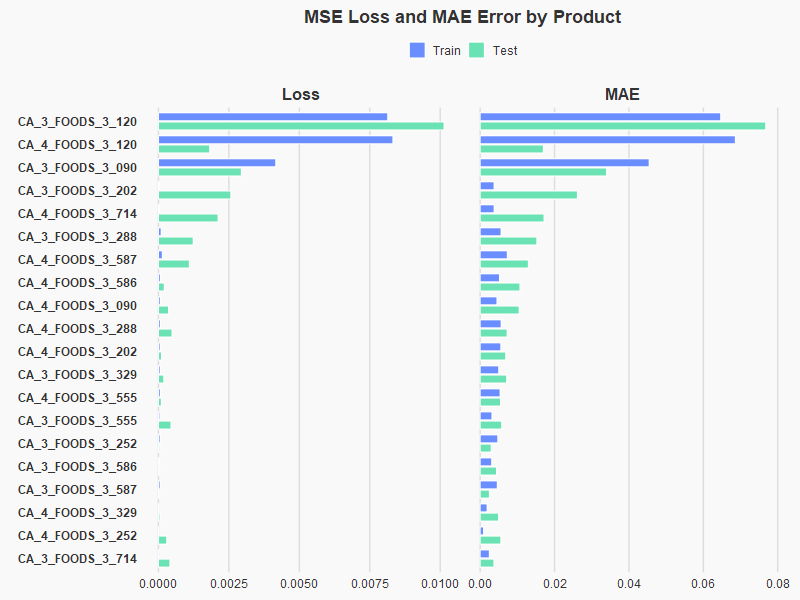

In [36]:
df_long = df_metricas %>%
  pivot_longer(cols = -Nombre, names_to = c("Metric", "Set"), names_sep = "_")


# Crear la gráfica con colores pastel más intensos
ggplot(df_long, aes(x = value, y = reorder(Nombre, value), fill = Set)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), width = 0.7, color = "white") +
  facet_wrap(~ Metric, scales = "free_x") +
  labs(x = NULL, y = NULL, title = "MSE Loss and MAE Error by Product") +
  scale_fill_manual(values = c("Train" = "#6A8DFF", "Test" = "#6AE2B3")) +  
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18, color = "#333333"),
    axis.text.y = element_text(face = "bold", color = "#333333"),
    axis.text.x = element_text(color = "#333333"),
    strip.text = element_text(face = "bold", size = 16, color = "#333333"),
    legend.title = element_blank(),
    legend.position = "top",
    legend.text = element_text(color = "#333333"),
    legend.key = element_rect(fill = NA),  
    panel.grid.major.x = element_line(color = "#DDDDDD"),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_blank(),
    axis.ticks = element_blank(),
    panel.background = element_rect(fill = "#F9F9F9", color = NA),
    plot.background = element_rect(fill = "#F9F9F9", color = NA),
    plot.margin = margin(10, 20, 10, 20) 
  ) +
  guides(fill = guide_legend(reverse = TRUE))

In [37]:
reverse_scaling = function(df, min_value, max_value) {

  df_reversed = df
  
  for (col_name in names(df)) {

    
    df_reversed[[col_name]] = ((df[[col_name]] + 1) / 2) * (max_value - min_value) + min_value

  }
  
  return(df_reversed)
}

In [38]:
lista_df_forecast = list()

for (i in seq_along(lista_forecast)) {
  if (i %% 2 != 0) {
    elemento_n = lista_forecast[[i]]
    elemento_n_1 = lista_forecast[[i + 1]]
    
    df_bucle = data.frame(Prediccion = elemento_n, Real = elemento_n_1)
    
    nombre_bucle = names(lista_forecast)[i] %>% str_remove("prediccion_")
    
    lista_df_forecast[[nombre_bucle]] = df_bucle
  }
}


In [39]:
lista_min_max_ventas = readRDS('../02_Variables/lista_min_max_ventas.rds')

Aplicamos la inversión del proceso de escalamiento y agregamos Date como variable.

In [40]:
for (elemento in names(lista_df_forecast)) {

  sufijo = str_remove(elemento, "df_")
  
  min = lista_min_max_ventas[[paste0("min_", sufijo)]]
  max = lista_min_max_ventas[[paste0("max_", sufijo)]]
  
  df_bucle = lista_df_forecast[[elemento]]
  
  df_bucle = reverse_scaling(df_bucle, min, max)
  
  lista_df_forecast[[elemento]] = df_bucle %>% cbind(Date)
  
}

In [48]:
saveRDS(lista_df_forecast, file = "../02_Variables/lista_df_forecast.rds")